# Conformer Generation Pipeline

## **Step 1: Input Smile and Reference Conformer**

In [1]:
import time

# Capture the start time
start_time: float = time.time()

In [2]:
import sys

# Add a folder to Python's import path
sys.path.append('/work')

In [3]:
from atk_conformer_generation_pipeline.utils import *
from atk_conformer_generation_pipeline.variables import *
import os
import glob
import re
import subprocess
from pyscf import gto
from pyscf.geomopt import geometric_solver
from gpu4pyscf.dft import rks
from pyscf.hessian import thermo
from termcolor import colored

In [4]:
#Change the dir to /work
os.chdir("/work")
!pwd

/work


**Change the below variables accordingly**

In [5]:
inp_smiles: str="NC(=O)CO"
dielectric_value: float=46.826
output_dir: str="refactored_test"
num_conf_rdkit: int = 10     # Number of conformers to be generated
E_avg_proton: float=-277.60  # E_H (solv) in kcal/mol
pKa_EXP: float=23.00 # Experimental pKa

# inp_smiles: str = "CCO"                     # Ethanol
# dielectric_value: float = 78.355            # Dielectric constant for water
# output_dir: str = "ethanol_test_2"            # New output folder
# num_conf_rdkit: int = 500                   # Fewer conformers needed for simple molecule
# E_avg_proton: float = -270.28               # kcal/mol, estimated E_H(solv) for water
# pKa_EXP: float = 15.9                       # Experimental pKa of ethanol


In [6]:
os.makedirs(output_dir, exist_ok=True)
os.chdir(output_dir)

In [7]:
!pwd

/work/refactored_test


In [8]:
import sys
sys.setrecursionlimit(10000)
# set the maximum depth of the Python interpreter stack. This stack depth is crucial for recursive function calls, 
# as it limits how deep the recursion can go before causing a RecursionError.

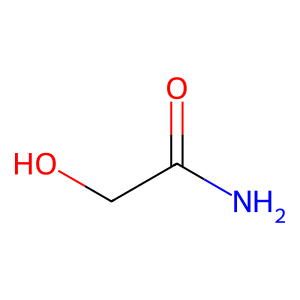

In [9]:
display_2d_structure(inp_smiles)

**Importing the necessary libraries**

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import shutil
import time
import os
import re
import shutil
import pandas as pd
import numpy as np
from numpy import loadtxt
import csv
from typing import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

In [11]:
%%time

### Remove all files and directories created in the previous execution to avoid any confusion

file_and_dir_to_remove: List[str]=[init_conf_xyz,opt_conf_xyz,opt_conf_energy_csv,opt_conf_SMILES_file,similarity_output_csv,
feasible_geometries_csv,infeasible_geometries_csv,feasible_geometries_xyz,infeasible_geometries_xyz,pairwise_RMSDs_dat,
pairwise_RMSDs_csv,cluster_reps_csv,cluster_reps_xyz,cluster_rep_prefix,cluster_reps_dir,clusters_RMSD_stats_csv,clusters_energy_stats_csv,
opt_cluster_reps_csv]

remove_paths(file_and_dir_to_remove)

The path initial_generated_conformers.sdf does not exist.
The path optimized_generated_conformers.sdf does not exist.
The path opt_conf_energies.csv does not exist.
The path optimized_generated_conformers.smi does not exist.
The path tanimoto_similarity.csv does not exist.
The path feasible_geom_energies.csv does not exist.
The path infeasible_geometries.csv does not exist.
The path feasible_geometries.xyz does not exist.
The path infeasible_geometries.xyz does not exist.
The path rmsd_matrix-mx_flags.dat does not exist.
The path pairwise_RMSDs.csv does not exist.
The path cluster_rep_conformers.csv does not exist.
The path cluster_rep_conformers.xyz does not exist.
The path rep_of_cluster_ does not exist.
The path cluster_rep_conformers does not exist.
The path cluster_statistics-RMSDs.csv does not exist.
The path cluster_statistics-energies.csv does not exist.
The path opt_cluster_rep_conformers.csv does not exist.
CPU times: user 391 µs, sys: 262 µs, total: 653 µs
Wall time: 467 µs


## **Step 2: Generating Conformers**

Generating conformers for a given molecule using the RDKit-ETKDG method.

In [12]:
%%time

import time
import sys


mol: Chem.Mol= generate_conformers(inp_smiles, num_conf_rdkit)  # Call the function to generate conformers
save_conformers_to_sdf(mol, init_conf_sdf)       # Save conformers to SDF file



CPU times: user 10.6 ms, sys: 751 µs, total: 11.4 ms
Wall time: 9.95 ms


In [13]:
# Find the number of atoms in the molecule
num_atoms_generated_conf: int = mol.GetNumAtoms()

## **Step 3: Optimizing Conformers**

In [14]:
%%time

### Optimize the generated conformers and save the optimized coordinates
opt_mol, conformer_energies = mmff_optimize_conformers(mol)     # Call the function to optimize conformers
save_conformers_to_sdf(opt_mol,opt_conf_sdf)
# print(conformer_energies)

num_opt_conf: int= opt_mol.GetNumConformers()


### Save the energies of optimized to a CSV file
conformer_energies_items : List[Tuple[int, float]] = list(conformer_energies.items())
energy_DF: pd.DataFrame = pd.DataFrame(conformer_energies_items, columns=['conformer_id', 'energy_in_kcalpermol'])
energy_DF.to_csv(opt_conf_energy_csv, index=False)

CPU times: user 10.1 ms, sys: 2.08 ms, total: 12.2 ms
Wall time: 11.9 ms


In [15]:
%%time

### Convert the 3D gometries of conformers into SMILES and save them
convert_conformers_to_smiles(opt_conf_sdf,opt_conf_SMILES_file)

CPU times: user 277 µs, sys: 43.5 ms, total: 43.8 ms
Wall time: 96.1 ms


10 molecules converted


In [16]:
### Process optimized conformers to calculate Tanimoto similarity and separate feasible and infeasible geometries.
infeasible_geom_DF, energy_DF=process_conformers(opt_conf_SMILES_file,opt_conf_sdf,feasible_geometries_sdf,infeasible_geometries_sdf,similarity_output_csv,infeasible_geometries_csv,inp_smiles,num_opt_conf,energy_DF)


In [17]:
%%time

### Calculate the numbers of conformers with feasible and infeasible geometries
num_feasible_geom: int = len(energy_DF)
num_infeasible_geom: int = len(infeasible_geom_DF)

with open("outputs.txt", 'a') as file:
    file.write(f'Number_of_feasible_geometries: {num_feasible_geom}\n')
    
print("Number of conformers with infeasible geometries:", num_infeasible_geom)
print("Number of conformers with feasible geometries:", num_feasible_geom)
print("Total number of conformers for which the geometry feasibility was checked:", num_infeasible_geom+num_feasible_geom)
print("Total number of conformers generated:", num_conf_rdkit)

Number of conformers with infeasible geometries: 0
Number of conformers with feasible geometries: 10
Total number of conformers for which the geometry feasibility was checked: 10
Total number of conformers generated: 10
CPU times: user 126 µs, sys: 86 µs, total: 212 µs
Wall time: 151 µs


In [18]:
%%time

### Calculate the relative energies of conformers and write the results to a CSV file.
rel_energy_DF: pd.DataFrame=calculate_relative_energies(energy_DF,feasible_geometries_csv)


CPU times: user 0 ns, sys: 1.7 ms, total: 1.7 ms
Wall time: 1.39 ms


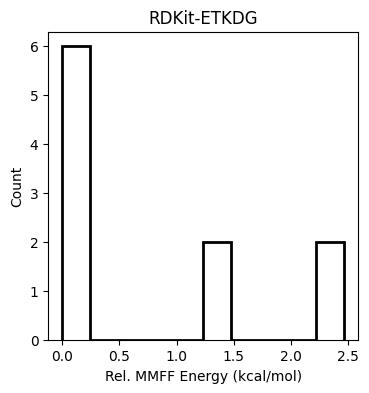

CPU times: user 283 ms, sys: 1.65 s, total: 1.93 s
Wall time: 84.5 ms


In [19]:
%%time

fig = plt.figure(figsize=(4, 4))

### Plot the relative energy distribution for conformers with feasible geometries
n_bins=10
plt.hist(rel_energy_DF['rel_energy_in_kcalpermol'], bins=n_bins, density=False, color='black', histtype='step', fill=False, lw=2)
#density=False: If True, the histogram is normalized so that the area under the histogram integrates to 1. If False, the histogram represents the count of occurrences in each bin.
#'bar': Traditional bar histogram (default)
plt.xlabel('Rel. MMFF Energy (kcal/mol)')
plt.ylabel('Count')
plt.title('RDKit-ETKDG')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("rel_MMFF_energies-count_histogram", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 4: Calculating RMSD Matrix**

Using Open Babel obrms command to calculate the Root Mean Square Deviation (RMSD) between the feasiable geometries present in an SDF file

In [20]:
%%time

### Run obrms on the concatenated sdf file of conformers with feasible geometries to compute RMSD matrix
calculate_rmsd(feasible_geometries_sdf,pairwise_RMSDs_dat)

RMSD calculation completed and appended to rmsd_matrix-mx_flags.dat.
CPU times: user 1.11 ms, sys: 12.1 ms, total: 13.2 ms
Wall time: 34.2 ms


In [21]:
%%time

from scipy.spatial.distance import squareform, is_valid_dm

### Read the pairwise RMSD matrix from the output of obrms; it is supposed to be a hollow, asymmetric matrix
rmsd_matrix_DF: pd.DataFrame = pd.read_csv(pairwise_RMSDs_dat, header=None, index_col=0)

### Convert the pairwise RMSD matrix into a numpy float-type 2D array
rmsd_matrix: np.ndarray = rmsd_matrix_DF.to_numpy(dtype=float)

### Round the matrix elements to two decimal places to avoid possible asymmetry in the matrix due to insignificant numerical errors
rmsd_matrix_2DP: np.ndarray  = np.round(rmsd_matrix, 2)

# Force the matrix to be symmetric
rmsd_matrix_2DP = (rmsd_matrix_2DP + rmsd_matrix_2DP.T) / 2

# Check if the matrix is symmetric
if not is_valid_dm(rmsd_matrix_2DP, throw=False):
    raise ValueError("The provided RMSD matrix is not symmetric even after rounding and forcing symmetry.")

CPU times: user 1.9 ms, sys: 880 µs, total: 2.78 ms
Wall time: 2.25 ms


In [22]:
%%time

### Convert the the pairwise distance matrix to its condensed form; write the pairwise RMSDs from the condensed matrix into a CSV file
from scipy.spatial.distance import squareform
condensed_matrix: np.ndarray  = squareform(rmsd_matrix_2DP)
pairwise_RMSDs_DF: pd.DataFrame = pd.DataFrame(condensed_matrix)
pairwise_RMSDs_DF.to_csv(pairwise_RMSDs_csv, header=['pairwise_RMSD'], index=False)

CPU times: user 873 µs, sys: 0 ns, total: 873 µs
Wall time: 686 µs


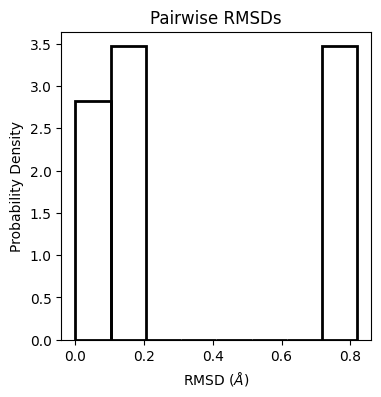

CPU times: user 255 ms, sys: 1.7 s, total: 1.95 s
Wall time: 109 ms


In [23]:
%%time

### Plot the distribution of pairwise RMSDs
fig = plt.figure(figsize=(4, 4))

### Plot the histograms
plt.hist(condensed_matrix, bins=8, density=True, color='black', fill=False, lw=2)

### Format the axes
plt.xlabel(r'RMSD ($\AA)$')
plt.ylabel('Probability Density')
plt.title('Pairwise RMSDs')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("pairwise_rmsd_distribution-PD.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 5: Hierarchical Cluster**

Clustering the generated conformers into 20 clusters using hierarchical clustering with `ward` linkage method. 

In [24]:
%%time

### Perform hierarchical clustering with 'ward' linkage method on the condensed version of pairwise distance matrix
import scipy.cluster.hierarchy as sch
linkage_matrix_ward: np.ndarray = sch.linkage(condensed_matrix, method='ward')

CPU times: user 1.27 ms, sys: 1.42 ms, total: 2.69 ms
Wall time: 2.36 ms


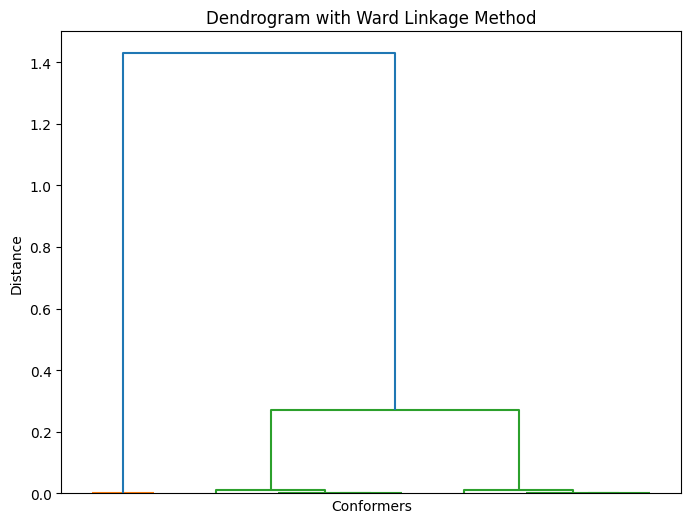

CPU times: user 73.4 ms, sys: 94.7 ms, total: 168 ms
Wall time: 60.2 ms


In [25]:
%%time

### A few settings to export the image of the plot
plt.style.use('default')
fig = plt.figure(figsize=(8, 6))

### Plot the dendrogram to visualize the hierarchical clustering structure
sch.dendrogram(linkage_matrix_ward, no_labels=True)
plt.title('Dendrogram with Ward Linkage Method')
plt.xlabel('Conformers')
plt.ylabel('Distance')
#plt.xticks(np.arange(0, 1000, 200))

### Show the plot
plt.show()

### Save figure
fig.savefig("hierarchical_clustering_dendogram-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

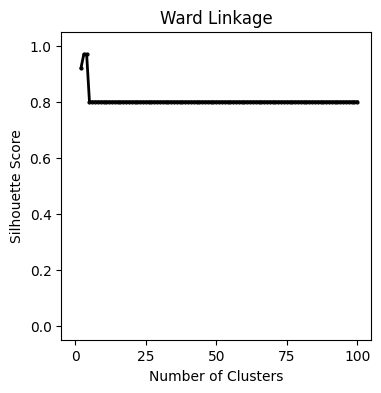

The optimal number of clusters is 3 with a silhouette score of 0.9697682709447417
CPU times: user 222 ms, sys: 77.8 ms, total: 300 ms
Wall time: 227 ms


In [26]:
%%time

### A few settings to export the image of the plot
# plt.style.use('~/matplotlib_templates/single_column.mplstyle')
fig = plt.figure(figsize=(4, 4))

### Determine the optimal number of clusters using silhouette score; the original pairwise RMSD matrix must be used for this
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from collections import Counter


## Calculate silhouette score for different numbers of clusters
sil_scores = []
range_n_clusters = list(range(2, 101))     # Try different numbers of clusters
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix_ward, n_clusters, criterion='maxclust')
    cluster_counts = Counter(cluster_labels)
    # print(cluster_counts)
    
    # Check if the clustering resulted in more than one cluster
    if len(cluster_counts) > 1:
        sil_score = silhouette_score(rmsd_matrix_2DP, cluster_labels, metric='precomputed')
        sil_scores.append(sil_score)
    else:
        sil_scores.append(float('-inf'))  # Append a very low score if there's only one cluster    


## Plot the Silhouette scores
plt.plot(range_n_clusters, sil_scores, marker='o', color='black', fillstyle='none', ms=2, lw=2)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Ward Linkage")
plt.axis([-5, 105, -0.05, 1.05])
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

### Show the plot
plt.show()

### Save figure
fig.savefig("silhouette_score_vs_num_clust-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## Find the optimal number of clusters based on the maximum value of silhouette score and printing it
max_sil_score = np.max(sil_scores)
optimal_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"The optimal number of clusters is {optimal_clusters} with a silhouette score of {max_sil_score}")

In [27]:
%%time

from scipy.cluster.hierarchy import linkage, fcluster

num_clusters = 5 if optimal_clusters > 5 else optimal_clusters

## For each conformer, assign the cluster label to which it belongs
cluster_labels: np.ndarray = fcluster(linkage_matrix_ward, num_clusters, criterion='maxclust')

## Create an empty dictionary to store the cluster sets
clusters: Dict[int, List[int]] = {i: [] for i in range(1, num_clusters + 1)}

## Assign each cluster label to the respective cluster set
for index, label in enumerate(cluster_labels):
    clusters[label].append(index)     # Store the indices instead of raw data
    

CPU times: user 120 µs, sys: 175 µs, total: 295 µs
Wall time: 100 µs


## **Step 6: Identifying Cluster Representative**

Identifying the minimum energy conformer within each cluster as its representative

In [28]:
%%time

### Identify the minimum energy conformer within each cluster as its representative

## Loop over all the cluster sets
cluster_reps_list: List[pd.DataFrame] = []

for clust_label, clust_elements in clusters.items():
    if len(clust_elements)!=0:
        clust_DF: pd.DataFrame = rel_energy_DF.loc[clust_elements]     # Extract the relative energies of the cluster elements into a dataframe
        min_energy_index: int = clust_DF['rel_energy_in_kcalpermol'].idxmin()     # Find the row index correspoding to the minimum relative energy conformer within the cluster 
        min_energy_DF: pd.DataFrame= clust_DF.loc[[min_energy_index]]     # Isolate the repesentative conformer's relative energy into a dataframe
        min_energy_DF['cluster_id'] = clust_label     # Add the 'cluster ID' information to the above dataframe
        # print(min_energy_DF)
        cluster_reps_list.append(min_energy_DF)     # Append the dataframe corresponding to each cluster representative into a list of dataframes

## Concatenate the dataframes of all cluster representatives into a single dataframe
cluster_reps_DF: pd.DataFrame = pd.concat(cluster_reps_list, ignore_index=True)

## Sort the cluster respresentatives samples by 'conformer_id' and save the sorted dataframe to a csv file
sorted_cluster_reps_DF: pd.DataFrame = cluster_reps_DF.sort_values(by='conformer_id', ascending=True)
sorted_cluster_reps_DF.to_csv(cluster_reps_csv, index=False)

CPU times: user 2.33 ms, sys: 4.49 ms, total: 6.82 ms
Wall time: 2.2 ms


In [29]:
%%time

###  Write the coordinates of cluster representative conformers to SDF files.
write_cluster_representatives(opt_conf_sdf,cluster_reps_dir,cluster_reps_sdf,sorted_cluster_reps_DF,cluster_reps_DF,cluster_rep_prefix,conf_extension)



Completed Writing the SDF files of cluster representative conformers
CPU times: user 2.12 ms, sys: 4.18 ms, total: 6.29 ms
Wall time: 2.05 ms


## **Step 7: Calculating the Minimum RMSD**

Calculating the min rmsd between refrence conformer and cluster representatives.

# calculating the min rmsd between refrence conformer and cluster representatives
result: float = calculate_min_rmsd(f"../{ref_confo_path}",cluster_reps_sdf)
print(f"Min RMSD 20 Clusters: {result}")

# Append the result to the text file
with open('outputs.txt', 'a') as file:
    file.write(f'Min_RMSD_20_cluster : {result}\n')

# Step 8: Geometry optimization of neutral conformers using DFT

In [30]:
!python /work/dft_main.py DFT {cluster_reps_dir} {dielectric_value} 

Found 3 SDF files in cluster_rep_conformers
Basis sets: ['aug-cc-pVDZ']
XC functionals: ['M06-2X']
Dielectric constant: 46.826
#INFO: **** input file is /work/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, removeHs=False)
        mol = next(molecules)  # Assuming you have one molecule in the SDF

        # Get the first conformer to access 3D coordinates
        conformer = mol.GetConformer()

        # Extract atomic symbols and coordinates
        atom_list =

# Step 9: Geometry optimization of charged conformers using DFT

In [31]:
# Basis and XC
basis_sets = ['aug-cc-pVDZ']
xc_functionals = ['M06-2X']  # Add more if needed

for basis in basis_sets:
        for xc in xc_functionals:
             # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

# Get list of SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*.sdf")))

# Loop over each SDF file
for sdf_path in sdf_files:
    sdf_filename = os.path.basename(sdf_path)
    sdf_stem = os.path.splitext(sdf_filename)[0]  # Remove .sdf extension

    for basis in basis_sets:
        for xc in xc_functionals:
            
            # Output file names
            new_filename = f"{sdf_stem}_{basis_tag}_{xc_tag}.sdf"
            new_filepath = os.path.join(cluster_reps_dir, new_filename)
            shutil.copy(sdf_path, new_filepath)
            print("Renamed output will be:", new_filepath)


Renamed output will be: cluster_rep_conformers/rep_of_cluster_1_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_2_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_3_aug-cc-pVDZ_M06-2X.sdf


In [32]:

# Define base paths
base_dir = f"/work/{output_dir}/cluster_rep_conformers"
treated_dir = os.path.join(base_dir, "treated")

# Run the external Python script
subprocess.run([
    "python",
    "/work/ionization_tool_with_ranking/main.py",
    base_dir
], check=True)

# Move all .sdf files from treated/ to base_dir
sdf_files = glob.glob(os.path.join(treated_dir, "*.sdf"))
for file_path in sdf_files:
    shutil.move(file_path, base_dir)

# Remove the treated directory
shutil.rmtree(treated_dir)



rep_of_cluster_2_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 5 with Mulliken charge -0.552785
Deprotonated molecule saved as '/work/refactored_test/cluster_rep_conformers/treated/rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonated.sdf'
rep_of_cluster_1_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 5 with Mulliken charge -0.566948
Deprotonated molecule saved as '/work/refactored_test/cluster_rep_conformers/treated/rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonated.sdf'
Missing charge file for rep_of_cluster_3.sdf, skipping.
Missing charge file for rep_of_cluster_2.sdf, skipping.
Missing charge file for rep_of_cluster_1.sdf, skipping.
rep_of_cluster_3_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 5 with Mulliken charge -0.552758
Deprotonated molecule saved as '/work/refactored_test/cluster_rep_conformers/treated/rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonated.sdf'


In [33]:
!python /work/dft_main.py DFT_DEPROTO {cluster_reps_dir} {dielectric_value} 

Found 3 SDF files in cluster_rep_conformers
Basis sets: ['aug-cc-pVDZ']
XC functionals: ['M06-2X']
Dielectric constant: 46.826
Charge of cluster_rep_conformers/rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonated.sdf: -1
#INFO: **** input file is /work/dft_main.py ****
from rdkit import Chem
from pyscf import gto, dft
from gpu4pyscf.dft import rks
from pyscf.geomopt import geometric_solver
import sys
import glob
import time
import re


import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"


class DFTClass:
    def __init__(self, sdf_path, eps):
        self.sdf_path= sdf_path
        self.eps=eps
    
    def get_atom_list(self):
        molecules = Chem.SDMolSupplier(self.sdf_path, removeHs=False)
        mol = next(molecules)  # Assuming you have one molecule in the SDF

        # Get the first conformer to access 3D coordinates
        conformer 

# Step 10: Accumulating DFT data and Writing the CSV for pKa Calculations

In [34]:
def create_dataframe_from_xyz_files(folder_path):
    """
    Creates a pandas DataFrame from .xyz files in a given folder,
    extracting Basis, XC, and energy.

    Args:
        folder_path (str): The path to the folder containing the .xyz files.

    Returns:
        pandas.DataFrame: A DataFrame with 'file name', 'Basis', 'XC', and 'energy' columns.
    """
    data = []

    # Updated Regex to match the filename pattern and capture Basis and XC
    # This regex is more robust to handle basis sets and XC functionals
    # that may contain hyphens, numbers, or specific characters.
    # It assumes the structure is:
    # rep_of_cluster_N_BASIS_XC_optional_treatment.xyz
    filename_pattern = re.compile(
        r"rep_of_cluster_(\d+)(?:_([a-zA-Z0-9\-]+)_([a-zA-Z0-9\-]+))?(?:_deprotonated|_protonated)?\.xyz"
    )

    for filename in os.listdir(folder_path):
        if filename.endswith(".xyz"):
            match = filename_pattern.match(filename)
            if match:
                basis = match.group(1)
                xc = match.group(2)

                file_path = os.path.join(folder_path, filename)
                try:
                    with open(file_path, 'r') as f:
                        f.readline()  # Skip the first line (number of atoms)
                        energy_line = f.readline().strip()

                        energy = None
                        try:
                            energy = float(energy_line)
                        except ValueError:
                            energy_match = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", energy_line)
                            if energy_match:
                                energy = float(energy_match.group(0))
                            else:
                                print(f"Could not extract energy from line: '{energy_line}' in file: {filename}")

                        data.append({
                            'file name': filename,
                            'Basis': basis,
                            'XC': xc,
                            'energy': energy
                        })
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")
            else:
                print(f"Filename pattern did not match for: {filename}")

    df = pd.DataFrame(data)
    return df

# --- How to use the function ---
if __name__ == "__main__":
    df = create_dataframe_from_xyz_files(cluster_reps_dir)


df.head(15)

    

,file name,Basis,XC,energy
0,rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonat...,2,aug-cc-pVDZ,-178141.480186
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,2,aug-cc-pVDZ,-178454.252420
2,rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonat...,3,aug-cc-pVDZ,-178141.492501
3,rep_of_cluster_3_aug-cc-pVDZ_M06-2X.xyz,3,aug-cc-pVDZ,-178454.248394
4,rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonat...,1,aug-cc-pVDZ,-178136.751490
5,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,1,aug-cc-pVDZ,-178454.429848


In [35]:

# ---
# Step 1: Extract the Common Prefix
def extract_prefix(filename):
    match = re.match(r'(rep_of_cluster_\d+_aug-cc-pVDZ_M06-2X)', filename)
    if match:
        return match.group(1)
    return filename

df['prefix'] = df['file name'].apply(extract_prefix)

# ---
# Step 2: Group and Process to Assign Custom Names, including Basis and XC

output_rows = []
for prefix, group in df.groupby('prefix'):
    row_dict = {'Prefix': prefix}
    
    # Get Basis and XC from the first row of the group (they should be constant within the group)
    # Using .iloc[0] is safe here because each group will have at least one row
    row_dict['Basis'] = group['Basis'].iloc[0]
    row_dict['XC'] = group['XC'].iloc[0]

    # Initialize placeholders for the new columns
    row_dict['Filename_original'] = None
    row_dict['Energy_original'] = None
    row_dict['Filename_acid_treated'] = None
    row_dict['Energy_acid_treated'] = None
    row_dict['Filename_base_treated'] = None
    row_dict['Energy_base_treated'] = None


    for _, entry in group.iterrows():
        filename = entry['file name']
        energy = entry['energy']

        if '_deprotonated' in filename:
            row_dict['Filename_deprotonated'] = filename
            row_dict['Energy_deprotonated'] = energy
        elif '_protonated' in filename:
            row_dict['Filename_protonated'] = filename
            row_dict['Energy_protonated'] = energy
        else:
            # Assuming files without _acid_treat or _base_treat are the 'original'
            row_dict['Filename_original'] = filename
            row_dict['Energy_original'] = energy
            
    output_rows.append(row_dict)

result_df = pd.DataFrame(output_rows)

# Reorder columns for better readability
# Ensure all these columns exist in result_df before attempting to reorder
desired_columns = ['Prefix', 'Basis', 'XC',
                   'Filename_original', 'Energy_original',
                   'Filename_deprotonated', 'Energy_deprotonated',
                   'Filename_protonated', 'Energy_protonated']

# Filter for only the columns that actually exist in result_df to avoid errors
existing_columns = [col for col in desired_columns if col in result_df.columns]
result_df = result_df[existing_columns]


#print
result_df

,Prefix,Basis,XC,Filename_original,Energy_original,Filename_deprotonated,Energy_deprotonated
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X,1,aug-cc-pVDZ,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,-178454.429848,rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonat...,-178136.751490
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X,2,aug-cc-pVDZ,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,-178454.252420,rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonat...,-178141.480186
2,rep_of_cluster_3_aug-cc-pVDZ_M06-2X,3,aug-cc-pVDZ,rep_of_cluster_3_aug-cc-pVDZ_M06-2X.xyz,-178454.248394,rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonat...,-178141.492501


# Step 11: Data analysis and pKa Calculation

In [36]:
if 'Energy_deprotonated' in result_df.columns:
    result_df['E_proton (acidic)']=pKa_EXP*1.36574 +(result_df['Energy_original'] -result_df['Energy_deprotonated'])
if 'Energy_protonated' in result_df.columns:
    result_df['E_proton (basic)']=pKa_EXP*1.36574 -(result_df['Energy_original'] -result_df['Energy_protonated'])



In [37]:
T = 298  # Temperature in Kelvin
k_B = 0.0019872041  # Boltzmann constant in kcal/mol·K

E_shifted = result_df['Energy_original'] - result_df['Energy_original'].min()  # shift energies so lowest is 0
weights = np.exp(-E_shifted / (k_B * T))

#Boltzmann Probabilities
result_df['Weights'] = weights / np.sum(weights)

if 'Energy_deprotonated' in result_df.columns and 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

elif 'Energy_deprotonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Weights' ]]

elif 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

result_df

,Prefix,Basis,XC,Energy_original,Energy_deprotonated,E_proton (acidic),Weights
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X,1,aug-cc-pVDZ,-178454.429848,-178136.751490,-286.266338,0.403684
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X,2,aug-cc-pVDZ,-178454.252420,-178141.480186,-281.360214,0.299172
2,rep_of_cluster_3_aug-cc-pVDZ_M06-2X,3,aug-cc-pVDZ,-178454.248394,-178141.492501,-281.343873,0.297145


In [38]:
#pKa Calculation weighted avg
if 'Energy_deprotonated' in result_df.columns:
    result_df.loc[:, 'pka (acidic)'] = 0.7322 * (
        E_avg_proton -
        (result_df['Energy_original'] - result_df['Energy_deprotonated'])
    )
    pka_cal_acidic = sum(result_df['pka (acidic)'] * result_df['Weights'])

if 'Energy_protonated' in result_df.columns:
    result_df.loc[:, 'pka (basic)'] = 0.7322 * (
        E_avg_proton + (result_df['Energy_original'] - result_df['Energy_protonated'])
    )
    pka_cal_basic = sum(result_df['pka (basic)'] * result_df['Weights'])

result_df.to_csv("cluster_rep_conformers/conformerwise_pka.csv", index=False)

# Print appropriate values
if 'pka_cal_acidic' in locals():
    print("pKa_calculated (acidic, weighted average):", pka_cal_acidic)
if 'pka_cal_basic' in locals():
    print("pKa_calculated (basic, weighted average):", pka_cal_basic)


pKa_calculated (acidic, weighted average): 27.19969354369422


/tmp/ipykernel_181245/251902270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.loc[:, 'pka (acidic)'] = 0.7322 * (


In [39]:
# Capture the end time
end_time: float = time.time()

# Calculate the execution time in seconds
execution_time_seconds: float = end_time - start_time

# Convert the execution time to minutes
execution_time_minutes: int = execution_time_seconds // 60

with open('outputs.txt', 'a') as file:
    file.write(f'Execution_time : {execution_time_minutes}\n')

In [40]:
# Create a DataFrame
data = {
    "Molecule": [inp_smiles],
    "Solvent (ε)": [dielectric_value],
    "# Conformers": [len(cluster_reps_DF)],
    "pKa (Exp)": [pKa_EXP],
}

try:
    data["pKa_cal_acidic (weighted avg)"] = [round(pka_cal_acidic, 1)]
except NameError:
    data["pKa_cal_acidic (weighted avg)"] = [np.nan]
try:
    data["pKa_cal_basic (weighted avg)"]= [round(pka_cal_basic, 1)]
except NameError:
    data["pKa_cal_basic (weighted avg)"]= [np.nan]

df_final = pd.DataFrame(data)
df_final.to_csv("cluster_rep_conformers/Final_cal_pka.csv",index=False)

df_final


,Molecule,Solvent (ε),# Conformers,pKa (Exp),pKa_cal_acidic (weighted avg),pKa_cal_basic (weighted avg)
0,NC(=O)CO,46.826,3,23.0,27.2,NaN
